In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sum_tree import SumTree
from replay_buffer import ReplayBuffer as RB, PrioritizedReplayBuffer as PRB

In [2]:
# Create instances of the uniform replay buffer and the prioritized replay buffer
t = 10000
rb = RB(state_dim=1, action_dim=1, max_size=40)
prb = PRB(
    state_dim=1, 
    action_dim=1, 
    max_size=40, 
    total_t=t, 
    alpha=0.6, 
    beta=0.4, 
    beta_schedule="annealing"
)

In [3]:
# Some experience, where the value also reflects the priority
priorities = np.arange(1, 30 + 1)
np.random.shuffle(priorities)
print(priorities)

[ 4 12 10 23 14  1 20  3 13  2  5 21 16 11 24  6 27 15  7  9 28 22 19 17
 26 29 18  8 30 25]


In [4]:
# Add all the experience to both buffers
for i, p in enumerate(priorities):
    rb.add(p, p, p, p, p)
    prb.add(p, p, p, p, p)

In [5]:
# Simulate sampling from both buffers
samples_uniform = []
samples_prioritized = []
w_is = []
batch_size = 5

for i in range(t):
    # Add samples (5 per batch)
    samples_uniform.append(rb.sample(batch_size)[0].cpu().data.numpy().flatten())
    
    batch, indices, importance_weights = prb.sample(batch_size)
    
    batch = batch[0].cpu().data.numpy().flatten()
    samples_prioritized.append(batch)
    w_is.append(importance_weights.cpu().data.numpy().flatten())
    
    # Update the priorities with their actual value (priority)
    for i in range(batch_size):
        prb.update(indices[i], batch[i])
        
samples_uniform = np.asarray(samples_uniform).flatten()
samples_prioritized = np.asarray(samples_prioritized).flatten()
w_is = np.asarray(w_is).flatten()

 -> Current maximal priority in the replay buffer: 3.485
 -> Current maximal priority in the replay buffer: 4.874
 -> Current maximal priority in the replay buffer: 6.733
 -> Current maximal priority in the replay buffer: 7.543
 -> Current maximal priority in the replay buffer: 7.698


In [6]:
# Make sure the sample sizes are correct
assert(samples_uniform.shape[0] == batch_size * t)
assert(samples_prioritized.shape[0] == batch_size * t)
assert(w_is.shape[0] == batch_size * t)

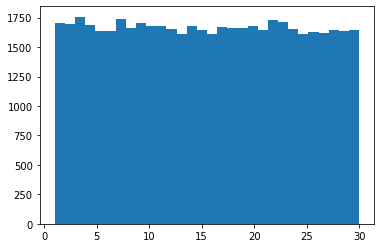

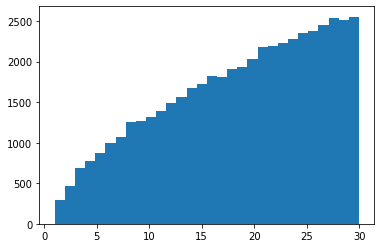

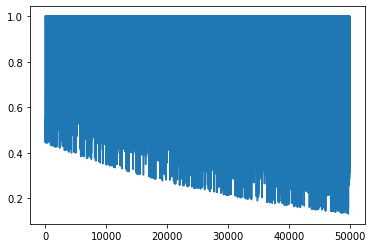

In [7]:
# Samples from rb should be uniform
plt.hist(samples_uniform, bins=30)
plt.show()

# Samples from prb should be monotonically rising
plt.hist(samples_prioritized, bins=30)
plt.show()

# The importance weights should be lower than 1 and have an annealing behaviour
plt.plot(w_is)
plt.show()